In [103]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from fancyimpute import KNN
from scipy.stats import chi2_contingency
import seaborn as sns
from random import randrange, uniform
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt # some plotting!
import seaborn as sns # so For Plots!
%matplotlib inline 
import matplotlib.pyplot as plt # some plotting!
import seaborn as sns # so For Plots!
#Feature importance plotting
from sklearn.ensemble import RandomForestRegressor

In [104]:
os.chdir("C:/Users/Sridhar/Desktop/project on prediction/prediction on cab/3")

## Reading The Data

In [105]:
#Load data
cabfare= pd.read_csv("train_cab.csv",parse_dates=['pickup_datetime'])
cabtest = pd.read_csv("test.csv", parse_dates=['pickup_datetime'])

## knowing structure of our data

In [106]:
cabfare.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [107]:
cabfare.describe(include='all')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16043,16067,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
unique,468,16021,NaN,NaN,NaN,NaN,NaN
top,6.5,2012-04-28 19:45:00 UTC,NaN,NaN,NaN,NaN,NaN
freq,759,2,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,NaN,NaN,10.578384,6.826587,10.575062,6.187087,60.844122
min,NaN,NaN,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,NaN,NaN,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,NaN,NaN,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,NaN,NaN,-73.966838,40.767381,-73.963643,40.768013,2.000000


In [108]:
cabfare.shape

(16067, 7)

In [109]:
#cabfare.dtypes
print('cabfare:', cabfare.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.8+ KB
cabfare: None


## Changing the data types of our variables
#  Data Cleaning

In [110]:
# Convert the fare amount field from an object to a float\n",
cabfare['fare_amount'] = pd.to_numeric(cabfare['fare_amount'], errors='coerce')
cabfare['pickup_datetime']=pd.to_datetime(cabfare['pickup_datetime'],errors='coerce')

In [111]:
#Changing the values to its absolute for easier calculation further
cabfare = cabfare[abs(cabfare["pickup_latitude"]) < 90] #One value is 401 deleting that
cabfare = cabfare[abs(cabfare["dropoff_latitude"]) < 90] #non greater than 90
cabfare = cabfare[abs(cabfare["pickup_longitude"]) < 180]
cabfare = cabfare[abs(cabfare["dropoff_longitude"]) < 180]

## Data Pre-Processing


In [112]:
#Deleting pasangers count where count > 8, as a cab can max hold 8 passengers and i want to avoid outliers so deleting it not imputing
index_pc = cabfare.loc[cabfare.passenger_count > 8,:].index
cabfare.drop(index_pc, axis = 0, inplace = True)

In [113]:
#deleting values greater than 100 or negative
index_fc = cabfare.loc[cabfare.fare_amount > 100,:].index
cabfare.drop(index_fc, axis = 0, inplace = True)

index_fc1 = cabfare.loc[cabfare.fare_amount < 0, :].index
cabfare.drop(index_fc1, axis = 0, inplace = True)

In [114]:
cabfare = cabfare.dropna(subset=['fare_amount'])
cabfare = cabfare.dropna(subset=['pickup_datetime'])

In [115]:
cabfare=cabfare.replace(0,np.nan)

In [116]:
cabfare.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0


In [117]:
#Datetime breakup and changinng the datatype to int(Feature Engineering)

cabfare['year']=cabfare['pickup_datetime'].dt.year
cabfare['month']=cabfare['pickup_datetime'].dt.month
cabfare['weekday']=cabfare['pickup_datetime'].dt.weekday
cabfare['hour']=cabfare['pickup_datetime'].dt.hour

In [118]:
cabfare=cabfare.drop('pickup_datetime',axis=1)

## Missing Value Analysis

In [119]:
total = cabfare.isnull().sum().sort_values(ascending=False)
percent = ((cabfare.isnull().sum()/cabfare.isnull().count()).sort_values(ascending=False))*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data.sort_values('Total', ascending = True)
missing_data

,Total,Percent
hour,0,0.000000
weekday,0,0.000000
month,0,0.000000
year,0,0.000000
fare_amount,1,0.006246
passenger_count,112,0.699606
dropoff_latitude,307,1.917671
dropoff_longitude,309,1.930164
pickup_latitude,310,1.936411
pickup_longitude,310,1.936411


In [120]:
#imputing with KNN
cabfare=pd.DataFrame(KNN(k=5).fit_transform(cabfare),columns=cabfare.columns, index=cabfare.index)

Imputing row 1/16009 with 0 missing, elapsed time: 89.778
Imputing row 101/16009 with 0 missing, elapsed time: 90.127
Imputing row 201/16009 with 0 missing, elapsed time: 90.140
Imputing row 301/16009 with 0 missing, elapsed time: 90.143
Imputing row 401/16009 with 0 missing, elapsed time: 90.149
Imputing row 501/16009 with 0 missing, elapsed time: 90.154
Imputing row 601/16009 with 0 missing, elapsed time: 90.173
Imputing row 701/16009 with 0 missing, elapsed time: 90.181
Imputing row 801/16009 with 0 missing, elapsed time: 90.190
Imputing row 901/16009 with 0 missing, elapsed time: 90.200
Imputing row 1001/16009 with 0 missing, elapsed time: 90.209
Imputing row 1101/16009 with 0 missing, elapsed time: 90.209
Imputing row 1201/16009 with 0 missing, elapsed time: 90.213
Imputing row 1301/16009 with 0 missing, elapsed time: 90.220
Imputing row 1401/16009 with 0 missing, elapsed time: 90.225
Imputing row 1501/16009 with 0 missing, elapsed time: 90.231
Imputing row 1601/16009 with 0 missi

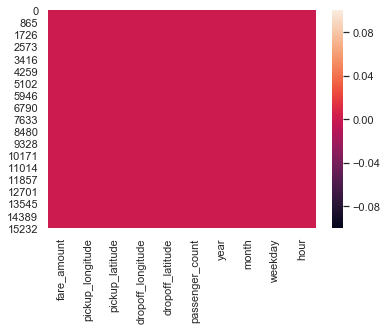

In [121]:
sns.heatmap(cabfare.isnull(), cbar=True)

In [122]:
cabfare['passenger_count']=cabfare['passenger_count'].astype(int)
cabfare['year']=cabfare['year'].astype(int)
cabfare['weekday']=cabfare['weekday'].astype(int)
cabfare['hour']=cabfare['hour'].astype(int)
cabfare['month']=cabfare['month'].astype(int)

## Visitualisation & Feature Engineering 

In [123]:
cabfare['abs_longi']=abs(cabfare['pickup_longitude']-cabfare['dropoff_longitude'])
cabfare['abs_lat']=abs(cabfare['pickup_latitude']-cabfare['dropoff_latitude'])

In [124]:
#Calculatig distance from log and lati with great circle formula
def great_circle_distance(lon1,lat1,lon2,lat2):
    R = 6371000 # Approximate mean radius of earth (in m)
    
    # Convert decimal degrees to ridians
    lon1,lat1,lon2,lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Distance of lons and lats in radians
    dis_lon = lon2 - lon1
    dis_lat = lat2 - lat1
    
    # Haversine implementation
    a = np.sin(dis_lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dis_lon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dis_m = R*c # Distance in meters
    dis_km = dis_m/1000 # Distance in km
    return dis_km
cabfare['distance'] = great_circle_distance(cabfare.pickup_longitude, cabfare.pickup_latitude, cabfare.dropoff_longitude, cabfare.dropoff_latitude)
cabfare.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,abs_longi,abs_lat,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17,0.002701,0.009041,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16,0.036780,0.070701,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0,0.008504,0.010708,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4,0.004437,0.024949,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7,0.011440,0.015754,1.999157


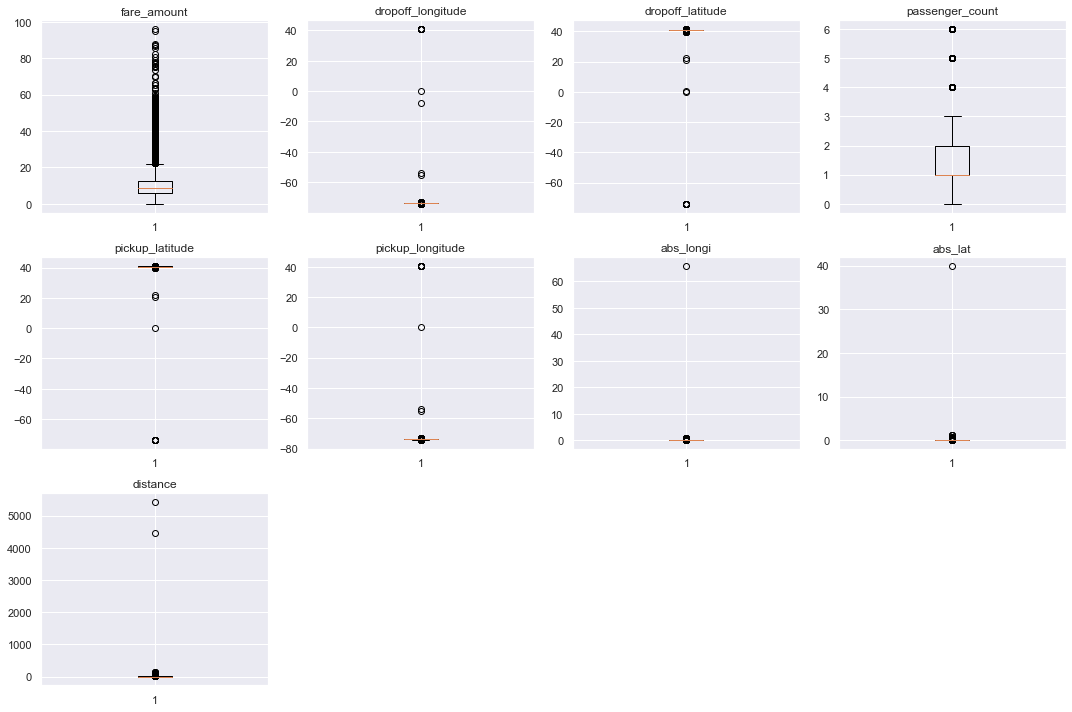

In [125]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 15
fig_size[1] = 10

plt.subplot(3,4,1)
plt.boxplot(cabfare['fare_amount'])
plt.title('fare_amount')

plt.subplot(3,4,2)
plt.boxplot(cabfare['dropoff_longitude'])
plt.title('dropoff_longitude')

plt.subplot(3,4,3)
plt.boxplot(cabfare['dropoff_latitude'])
plt.title('dropoff_latitude')

plt.subplot(3,4,4)
plt.boxplot(cabfare['passenger_count'])
plt.title('passenger_count')

plt.subplot(3,4,5)
plt.boxplot(cabfare['pickup_latitude'])
plt.title('pickup_latitude')

plt.subplot(3,4,6)
plt.boxplot(cabfare['pickup_longitude'])
plt.title('pickup_longitude')

plt.subplot(3,4,7)
plt.boxplot(cabfare['abs_longi'])
plt.title('abs_longi')

plt.subplot(3,4,8)
plt.boxplot(cabfare['abs_lat'])
plt.title('abs_lat')

plt.subplot(3,4,9)
plt.boxplot(cabfare['distance'])
plt.title('distance')

plt.tight_layout()

In [126]:
cabfare.shape

(16009, 13)

## Feature Selection

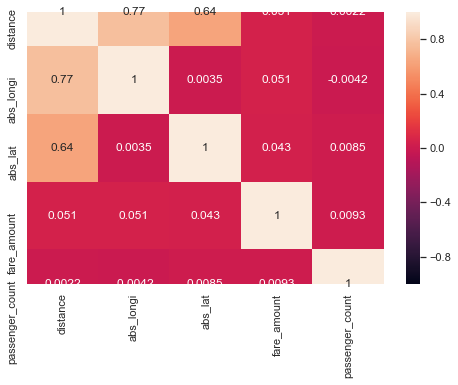

In [127]:
sns.set(rc={'figure.figsize':(8,5)})

cabfare['passenger_count'] = cabfare['passenger_count'].astype(int)
colname = ['distance','abs_longi','abs_lat','fare_amount','passenger_count']
heat_map = cabfare[colname]
sns.heatmap(heat_map.corr(), vmin=-1.00, vmax=1.00, annot=True)

In [128]:
#considering taxi ride is limited to certain distance will keep this at 100Km
cabfare = cabfare[cabfare["distance"] < 100]
cabfare = cabfare[cabfare["distance"] > 0]

#Droping the 66.00839 from abs_longi and 39.99361 from abs_lat which is not contributing much but just a noice, which i understood from my visualization
cabfare['abs_longi'] = cabfare['abs_longi'].replace(66.00839, np.nan)
cabfare['abs_lat'] = cabfare['abs_lat'].replace(39.99361, np.nan)

cabfare = cabfare.dropna(subset=['abs_longi'])
cabfare = cabfare.dropna(subset=['abs_lat'])

In [129]:
print("Skewness: %f" % cabfare['fare_amount'].skew())

Skewness: 2.951269


Text(0, 0.5, 'Importance')

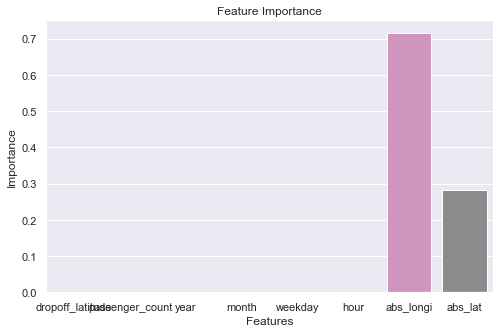

In [130]:
names=list(cabfare)
names = names[4:12]

fea = RandomForestRegressor(n_estimators = 100, random_state = 126).fit(cabfare.iloc[:,4:12],cabfare.iloc[:,12])

sns.barplot(x = names ,y = fea.feature_importances_)  

plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

In [131]:
#function for printing all variables for normalization analysis\n",
def plot_displot(df1,features):
    q = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,2,figsize=(15,15))
    for feature in features:
        q += 1
        plt.subplot(2,2,q)
        sns.distplot(df1[feature])
        plt.xlabel(feature, fontsize=9)
    plt.show(); 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001975E64E488>,
      dtype=object)

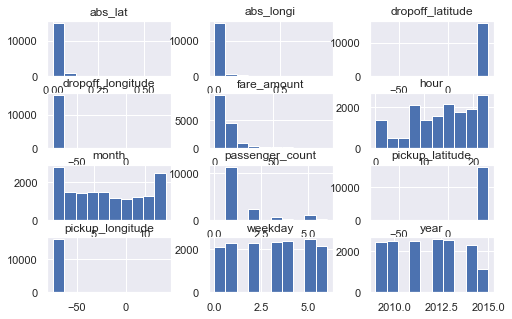

In [132]:
#Normality check
#cnames = ["fare_amount","distance","dropoff_longitude","dropoff_latitude","passenger_count","pickup_latitude","pickup_longitude","abs_longi","abs_lat"]
cnames = cabfare.iloc[:,0:12]
df=  pd.DataFrame(cnames)
df.to_csv( "normal.csv",index = False)
data = pd.read_csv("normal.csv")
data.hist()

In [133]:
#Normalisation
cnames = ["distance","year","month","weekday","hour","abs_longi","abs_lat","passenger_count"]
for i in cnames:
    print(i)
    cabfare[i] = (cabfare[i] - min(cabfare[i]))/(max(cabfare[i]) - min(cabfare[i]))

distance
year
month
weekday
hour
abs_longi
abs_lat
passenger_count


In [134]:
cabfare.shape

(15847, 13)

## Modeling

In [135]:
# Modeling 
from sklearn import metrics
#function to check performance  
def performance(actual, predict):
    print('MSE:', metrics.mean_squared_error(actual, predict)) 
    print('RMSE:', np.sqrt(metrics.mean_squared_error(actual, predict))) 
    print('MAPE:',np.mean(np.abs((actual-predict)/actual))*100)
    print('R-Sq:', metrics.r2_score(actual, predict))

In [136]:
##Sampling
##Sampling: dividing  Test and train data 
from sklearn.model_selection import train_test_split,KFold, cross_val_score, cross_val_predict
import copy
#moving the amount to last variable
cabfare['amount']= copy.copy(cabfare['fare_amount'])
cabfare = cabfare.drop(['fare_amount'], axis=1)

#Random sample selection 
train, test = train_test_split(cabfare, test_size = 0.25, random_state = 100)
cabfare.shape, test.shape , train.shape, #Gtest.shape

((15847, 13), (3962, 13), (11885, 13))

 ## 1.Decision Tree 

In [137]:
dt2 = DecisionTreeRegressor(max_depth =5, random_state=123).fit(train.iloc[:,4:12],train.iloc[:,12])
prediction_dt2 = dt2.predict(test.iloc[:,4:12])

#error matrix
performance(test.iloc[:,12],prediction_dt2)
print('                           ')
print('Perdicted Vs Actual value: ')
prediction_dt2[1], test.iloc[1,12]

MSE: 22.59741401816809
RMSE: 4.753673739137772
MAPE: 24.479560980812174
R-Sq: 0.7615780761803278
                           
Perdicted Vs Actual value: 


(9.965039370078754, 9.7)

In [138]:
dt2.score(train.iloc[:,4:12],train.iloc[:,12])

0.8327476465586343

## 2. Random Forest

In [139]:
#Random sample selection 
train1, test1 = train_test_split(cabfare, test_size = 0.25, random_state = 500)

In [140]:
from sklearn.ensemble import RandomForestRegressor
rf2 = RandomForestRegressor(n_estimators = 500, random_state = 126).fit(train1.iloc[:,4:12],train1.iloc[:,12])
prediction_rf2 = rf2.predict(test1.iloc[:,4:12])

#error matrix
performance(test1.iloc[:,12],prediction_rf2)
print('                           ')
print('Perdicted Vs Actual value: ')
prediction_rf2[1], test1.iloc[1,12]

MSE: 15.044944482160256
RMSE: 3.8787813140418543
MAPE: 22.665488144452773
R-Sq: 0.8198085296521344
                           
Perdicted Vs Actual value: 


(30.026480000000017, 28.1)

In [141]:
rf2.score(train1.iloc[:,4:12],train1.iloc[:,12])

0.9748056326115163

## 3.Linear Regression

In [142]:
#Random sample selection 
train2, test2 = train_test_split(cabfare, test_size = 0.25, random_state = 100)

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

ln3 = LinearRegression().fit(train2.iloc[:,4:12],train2.iloc[:,12])
prediction_slr3 = ln3.predict(test2.iloc[:,4:12])

#error matrix
performance(test2.iloc[:,12],prediction_slr3)
print('                           ')
print('Perdicted Vs Actual value: ')
prediction_slr3[1], test2.iloc[1,12]

MSE: 26.883175203959812
RMSE: 5.18489876506377
MAPE: 26.886085129363902
R-Sq: 0.7163596531286189
                           
Perdicted Vs Actual value: 


(10.46119589689815, 9.7)

In [144]:
ln3.score(train2.iloc[:,4:12],train2.iloc[:,12])

0.6561606144278074

## Visualisation For Actual vs Predict

Text(0, 0.5, 'Predicted values')

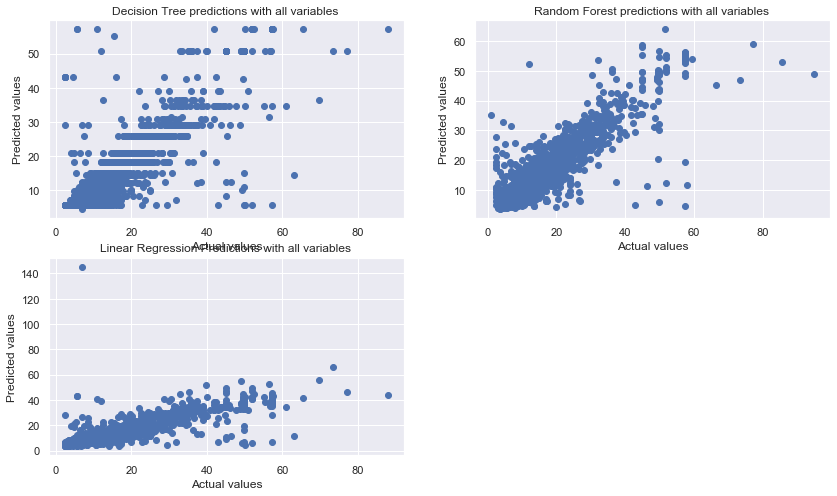

In [145]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.title('Decision Tree predictions with all variables ')
plt.scatter(test.iloc[:,12] , prediction_dt2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,2,2)
plt.title('Random Forest predictions with all variables ')
plt.scatter(test1.iloc[:,12] , prediction_rf2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,2,3)
plt.title('Linear Regression Predictions with all variables ')
plt.scatter(test2.iloc[:,12] , prediction_slr3)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Implementation on Test dataset

In [146]:
cabtest['pickup_datetime'] = pd.to_datetime(cabtest['pickup_datetime'], errors='coerce')
cabtest = cabtest.dropna(subset=['pickup_datetime'])

In [147]:
cabtest['year']=cabtest['pickup_datetime'].dt.year
cabtest['month']=cabtest['pickup_datetime'].dt.month
cabtest['weekday']=cabtest['pickup_datetime'].dt.weekday
cabtest['hour']=cabtest['pickup_datetime'].dt.hour

In [148]:
cabtest['abs_longi']=abs(cabtest['pickup_longitude']-cabtest['dropoff_longitude'])
cabtest['abs_lat']=abs(cabtest['pickup_latitude']-cabtest['dropoff_latitude'])

In [149]:
cabtest['distance'] = great_circle_distance(cabtest.pickup_longitude, cabtest.pickup_latitude, cabtest.dropoff_longitude, cabtest.dropoff_latitude)

In [150]:
cabtest['passenger_count']=cabtest['passenger_count'].astype(int)
cabtest['year']=cabtest['year'].astype(int)
cabtest['weekday']=cabtest['weekday'].astype(int)
cabtest['hour']=cabtest['hour'].astype(int)
cabtest['month']=cabtest['month'].astype(int)

In [151]:
cabtest.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,abs_longi,abs_lat,distance
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,0.008110,0.019970,2.323259
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,0.012024,0.019817,2.425353
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,0.002870,0.005121,0.618628
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,0.009288,0.016172,1.961033
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,0.022519,0.045348,5.387301


In [152]:
cabtest.describe(include = 'all')

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,abs_longi,abs_lat,distance
count,9914,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
unique,1753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-12-13 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2009-01-01 11:04:24+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-06-30 20:03:50+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-73.974722,40.751041,-73.973657,40.751743,1.671273,2011.815816,6.857979,2.852834,13.467420,0.023348,0.022133,3.435371
std,NaN,0.042774,0.033541,0.039072,0.035435,1.278747,1.803347,3.353272,1.994451,6.868584,0.036719,0.025589,3.972374
min,NaN,-74.252193,40.573143,-74.263242,40.568973,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,-73.992501,40.736125,-73.991247,40.735254,1.000000,2010.000000,4.000000,1.000000,8.000000,0.006354,0.007279,1.298277


In [153]:
cabtest = cabtest.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'], axis=1)

In [154]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 127).fit(train.iloc[:,4:12],train.iloc[:,12])
amount = rf.predict(cabtest)

cabtest ['amount'] = amount

In [155]:
cabtest.head(2)

,passenger_count,year,month,weekday,hour,abs_longi,abs_lat,distance,amount
0,1,2015,1,1,13,0.008110,0.019970,2.323259,30.95476
1,1,2015,1,1,13,0.012024,0.019817,2.425353,31.06370


In [156]:
cabtest.to_csv("Fare_Amount_Predicted.csv")

Text(0.5, 1.0, 'fare_amount')

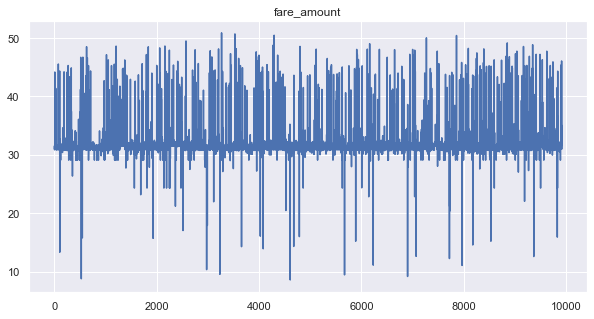

In [157]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.plot(cabtest['amount'])
plt.title('fare_amount')